In [16]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [17]:
from langchain_ollama.chat_models import ChatOllama

llm = ChatOllama(model="cow/gemma2_tools:2b")

In [18]:
embed_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

/tmp/ipykernel_5181/3414252995.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embed_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


In [19]:
llm.invoke("longest river in india")

AIMessage(content='The longest river in India is the **Ganga**. \r\n', additional_kwargs={}, response_metadata={'model': 'cow/gemma2_tools:2b', 'created_at': '2024-12-05T12:44:33.105476915Z', 'done': True, 'done_reason': 'stop', 'total_duration': 5541115291, 'load_duration': 4998775112, 'prompt_eval_count': 21, 'prompt_eval_duration': 261000000, 'eval_count': 14, 'eval_duration': 279000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-b5107e36-c2b4-4718-a921-0f72fd324811-0', usage_metadata={'input_tokens': 21, 'output_tokens': 14, 'total_tokens': 35})

In [20]:
from langchain.vectorstores import FAISS


urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=750, chunk_overlap=150, length_function = len
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
DB = FAISS.from_documents(
    doc_splits, embed_model)


db_retriever = DB.as_retriever()

In [21]:
def _format_docs(docs):
    info = [i.page_content for i in docs]
    return "\n\n".join(info)


In [22]:
kk = db_retriever.invoke("agents")
_format_docs(kk)

"Citation#\nCited as:\n\nWeng, Lilian. (Jun 2023). “LLM-powered Autonomous Agents”. Lil’Log. https://lilianweng.github.io/posts/2023-06-23-agent/.\n\nLLM Powered Autonomous Agents | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\nemojisearch.app\n\n\n\n\n\n\n\n\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nAgent System Overview\n\nComponent One: Planning\n\nTask Decomposition\n\nSelf-Reflection\n\n\nComponent Two: Memory\n\nTypes of Memory\n\nMaximum Inner Product Search (MIPS)\n\n\nComponent Three: Tool Use\n\nCase Studies\n\nScientific Discovery Agent\n\nGenerative Agents Simulation\n\nProof-of-Concept Examples\n\n\nChallenges\n\nCitation\n\nReferences\n\nGenerative Agents Simulation#\nGenerative Agen

In [23]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    db_retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.",
)

my_tools = [retriever_tool]

In [24]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


In [25]:
from pydantic import BaseModel, Field
# Data model
class grade(BaseModel):
    """Binary score for relevance check."""
    
    binary_score: str = Field(description="Relevance score 'yes' or 'no'")

In [26]:
llm_soutput = llm.with_structured_output(grade) 

In [27]:
# Prompt
from langchain.prompts import PromptTemplate

prompt = PromptTemplate(
    template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
    Here is the retrieved document: \n\n {context} \n\n
    Here is the user question: {question} \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
    input_variables=["context", "question"],
)

In [28]:
llm_grader = (prompt | llm_soutput)

In [30]:
q = "Who will win cricket match today"
llm_grader.invoke({"question":q,  "context":_format_docs(db_retriever.invoke("who will win match today"))})

grade(binary_score='no')

In [31]:
from langchain_core.output_parsers import StrOutputParser

template_rag = """
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know.
Use three sentences maximum and keep the answer concise.
If answer not in the context just say I dont know. Dont try to makeup an answer
Question: {question} 
Context: {context} 
Answer:
"""

prompt_rag = PromptTemplate.from_template(template_rag)

llm_rag = (prompt_rag | llm | StrOutputParser())

In [32]:
class AgentState(TypedDict):
    question : str
    docs : str
    generated_answer :  str
    ### yes, no
    similarity : str

In [33]:
from duckduckgo_search import DDGS

result = DDGS().text("who is precident of india",max_results=3)

RatelimitException: https://links.duckduckgo.com/d.js?q=who+is+precident+of+india&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-15730264448289718590023908591145930266&bing_market=wt-WT&ex=-1 202 Ratelimit

In [ ]:
[i['body'] for i in result]

['The president of India is the head of state of the Republic of India and the Supreme Commander of the Indian Armed Forces.The president is referred to as the first citizen of India. [1] [2] Although vested with these powers by the Constitution of India, the position is largely a ceremonial one and executive powers are de facto exercised by the prime minister.',
 'The president of India (ISO: Bhārata kē Rāṣṭrapati) is the head of state of the Republic of India.The president is the nominal head of the executive, [a] the first citizen of the country, as well as the supreme commander of the Indian Armed Forces. Droupadi Murmu is the 15th and current president, having taken office from 25 July 2022.. The office of president was created when India ...',
 'The President of India, Smt Droupadi Murmu paid floral tributes to Dr Rajendra Prasad, the first President of India on his birth anniversary at Rashtrapati Bhavan on December 3, 2024. Officer Trainees of Indian Revenue Service (Customs an

In [60]:

def retrieve_docs(state):
    print("--- Retriever ---")

    docs = db_retriever.invoke(state["question"])
    docs = _format_docs(docs)

    state["docs"] = docs

    return state



def relevance_check(state):

    print("---- check relevance ---")

    question = state["question"]
    docs = db_retriever.invoke(question)[0]
    score = llm_grader.invoke({"question": question, "context": docs })
    state["similarity"] = score.binary_score
    print("similarity", score)
    
    return state


def ROUTER(state):
    score = state["similarity"]
    if score == "yes":
        return "yes"
    else:
        return "no"    


def find_answer(state):
    print("--- finding answers ---")
    question = state["question"]
    docs = state["docs"]
    answer = llm_rag.invoke({"question": question, "context": docs})
    print("answer")
    state["generated_answer"] = answer 

    return state

def web_search_tool(state):
    print("--- web search tool ---")
    question = state["question"]
    result = DDGS().text(question,max_results=3)
    docs = [i["body"] for i in result]
    docs = "\n\n".join(docs)
    state["docs"] = docs
    return state

def pretty_print(state):
    print("--- preety print ---")
    print("Question: ",state["question"])
    print("Answer: "  ,state["generated_answer"])

In [61]:
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver


memory = MemorySaver()
config = {"configurable": {"thread_id":"1"}}

In [62]:
workflow = StateGraph(AgentState)

### nodes
# workflow.add_node("agent",agent)
workflow.add_node("db_retriever", retrieve_docs)
workflow.add_node("relevance_check",relevance_check)
workflow.add_node("find_answer", find_answer)
workflow.add_node("web_search_tool",web_search_tool)
workflow.add_node("pretty_print",pretty_print)

### edges
workflow.add_edge(START, "db_retriever")
workflow.add_edge("db_retriever", "relevance_check")
workflow.add_conditional_edges("relevance_check",ROUTER, {"yes": "find_answer", "no": "web_search_tool"} )
workflow.add_edge("web_search_tool","find_answer")
workflow.add_edge("find_answer", "pretty_print")
workflow.add_edge("pretty_print", END)


# graph = workflow.compile(checkpointer=memory)
graph = workflow.compile()


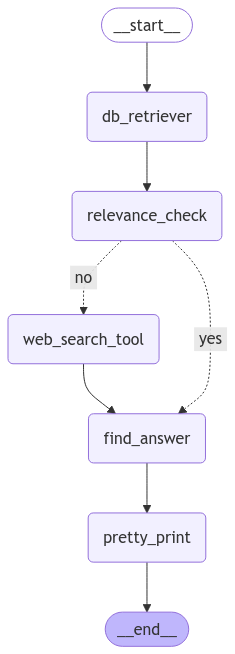

In [63]:
from IPython.display import Image,display

Image(graph.get_graph().draw_mermaid_png())


In [64]:
inputs = {"question": "Who won cricket world cup in 2024?"}
graph.invoke(inputs)

--- Retriever ---
---- check relevance ---
similarity binary_score='no'
--- web search tool ---
--- finding answers ---
answer
--- preety print ---
Question:  Who won cricket world cup in 2024?
Answer:  India won the Cricket World Cup in 2024.
 
 They defeated South Africa by a margin of 7 runs.  




{'question': 'Who won cricket world cup in 2024?',
 'docs': "The 2024 ICC Men's T20 World Cup final was a Twenty20 International cricket match played at Kensington Oval in Bridgetown, Barbados on 29 June 2024 to determine the winner of the 2024 ICC Men's T20 World Cup. [1] [2] It was played between South Africa and India.[3]India defeated South Africa by 7 runs to win their second T20 World Cup title. [4] Virat Kohli was named Player of the Match for ...\n\nIndia produced a brilliant performance to defeat South Africa in a dramatic men's T20 World Cup final, ending a long 13-year wait for the cricket-obsessed nation since its last World Cup win.\n\nJasprit Bumrah turns match around while Suryakumar Yadav takes match-winning catch as India become world champions again with 7-run win. ... and teammates celebrate with the winners trophy after defeating South Africa in the ICC Men's T20 World Cup final cricket match at Kensington Oval in Bridgetown, Barbados, Saturday, June 29, 2024 ...",
